<a href="https://colab.research.google.com/github/chandrakanta-chaudhury/Misc/blob/master/noise_removal_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://groups.inf.ed.ac.uk/ami/download/temp/amiBuild-62525-Mon-Mar-30-2020.wget.sh

--2020-03-30 06:51:54--  http://groups.inf.ed.ac.uk/ami/download/temp/amiBuild-62525-Mon-Mar-30-2020.wget.sh
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2233 (2.2K) [application/x-sh]
Saving to: ‘amiBuild-62525-Mon-Mar-30-2020.wget.sh’

amiBuild-62525-Mon- 100%[===================>]   2.18K  --.-KB/s    in 0s      

2020-03-30 06:51:54 (333 MB/s) - ‘amiBuild-62525-Mon-Mar-30-2020.wget.sh’ saved [2233/2233]



In [2]:
!ls

amiBuild-62525-Mon-Mar-30-2020.wget.sh	sample_data


In [3]:
!sh amiBuild-62525-Mon-Mar-30-2020.wget.sh

--2020-03-30 06:52:26--  http://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2008a/audio/ES2008a.Array1-01.wav
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33387564 (32M) [audio/x-wav]
Saving to: ‘amicorpus/ES2008a/audio/ES2008a.Array1-01.wav’

ES2008a.Array1-01.w 100%[===================>]  31.84M  15.3MB/s    in 2.1s    

2020-03-30 06:52:28 (15.3 MB/s) - ‘amicorpus/ES2008a/audio/ES2008a.Array1-01.wav’ saved [33387564/33387564]

--2020-03-30 06:52:28--  http://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2008a/audio/ES2008a.Array1-02.wav
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33387564 (32M) [audio/x-wav]
Saving to: ‘amicorpus/ES20

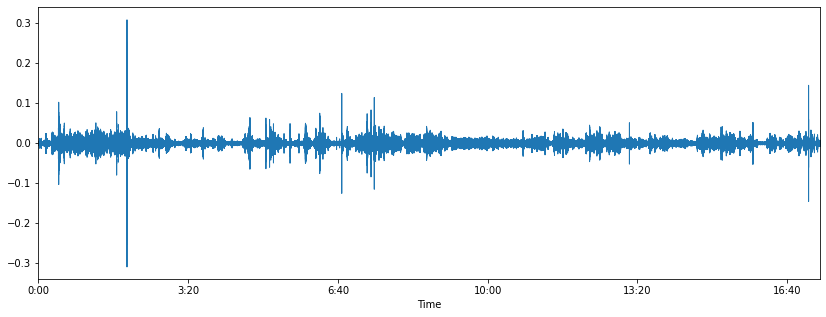

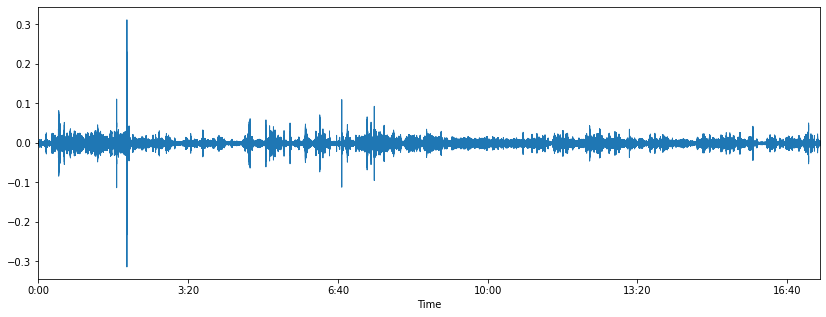

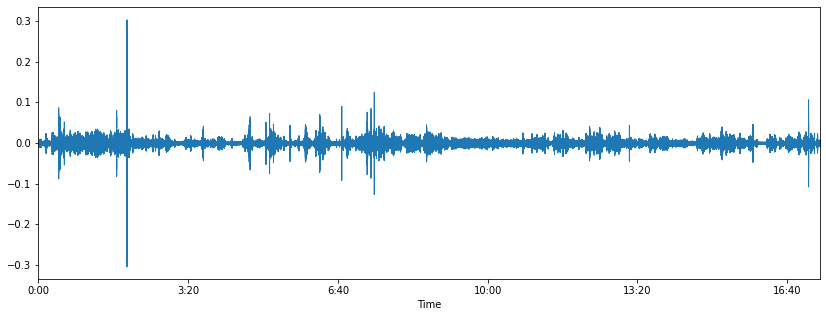

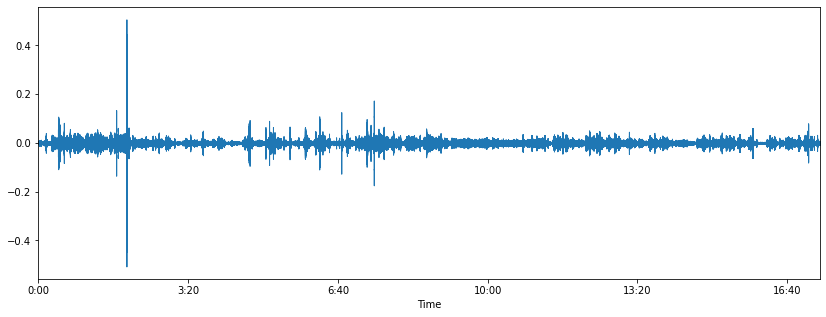

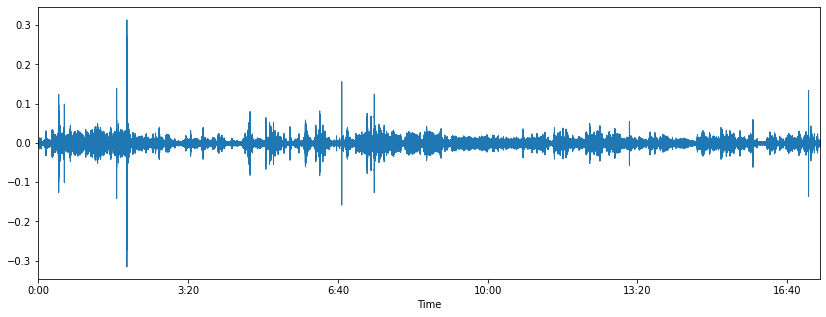

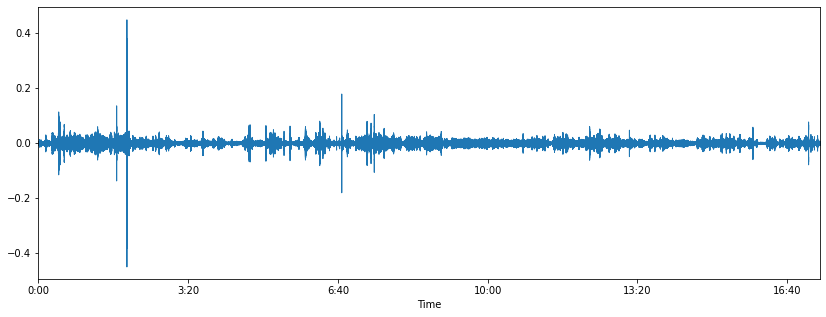

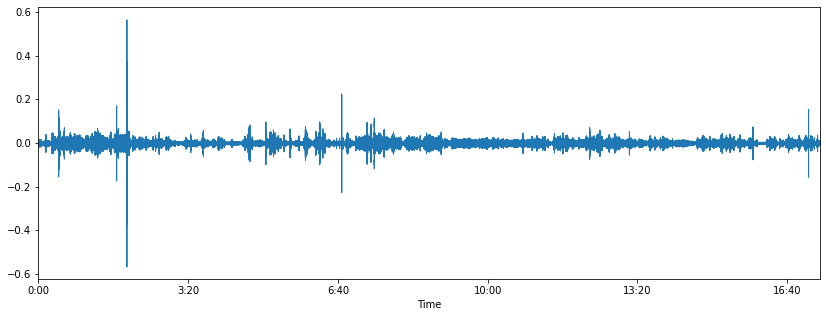

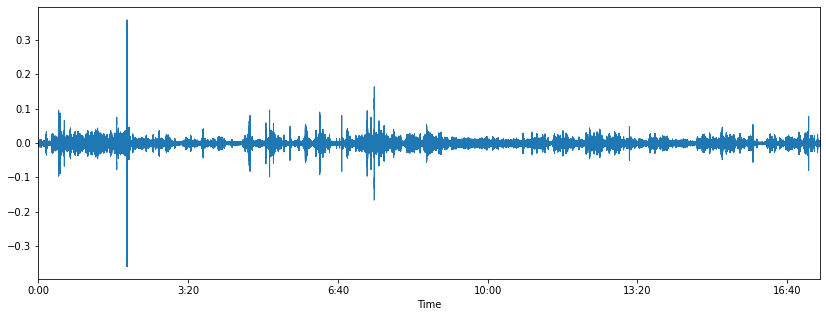

In [1]:
import librosa
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

# loop over all files in the current directory ending with .txt
for fname in glob("/content/amicorpus/ES2008a/audio/ES2008a.Array1-0*.wav"):
  x , sr = librosa.load(fname)
  import librosa.display
  plt.figure(figsize=(14, 5))
  librosa.display.waveplot(x,sr=sr)

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant

In [2]:
x.shape

(23006088,)

In [3]:
from glob import glob
import numpy as np
import librosa
X = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
#for fname in glob("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.A*-07.wav"):
for fname in glob("/content/amicorpus/ES2008a/audio/ES2008a.Array1-0*.wav"):  
    #struct = fname.split('_')
    #digit = struct[0]
    print(fname)
    wav, sr = librosa.load(fname)
    padded = pad(wav, 30000)
    X.append(padded)

/content/amicorpus/ES2008a/audio/ES2008a.Array1-05.wav
/content/amicorpus/ES2008a/audio/ES2008a.Array1-01.wav
/content/amicorpus/ES2008a/audio/ES2008a.Array1-06.wav
/content/amicorpus/ES2008a/audio/ES2008a.Array1-08.wav
/content/amicorpus/ES2008a/audio/ES2008a.Array1-04.wav
/content/amicorpus/ES2008a/audio/ES2008a.Array1-02.wav
/content/amicorpus/ES2008a/audio/ES2008a.Array1-03.wav
/content/amicorpus/ES2008a/audio/ES2008a.Array1-07.wav


In [0]:
X=np.vstack(X)

In [6]:
X.shape

(8, 30000)

In [0]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        #assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        print(idx)
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        print("check")
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        print("build inside")
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):
        print("call check")
        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
rbflayer = RBFLayer(X.shape[0],
                        initializer=InitCentersRandom(X),
                        betas=1.0,
                        input_shape=(X.shape[1],))

check


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2)

In [15]:
X_train.shape ,X_test.shape

((6, 30000), (2, 30000))

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 2000

In [0]:
from tensorflow.keras.layers import Input
input_layer = Input(shape=(input_dim, ))

In [0]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model

In [0]:
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [0]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

 

In [27]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 6.5917e-04 - accuracy: 0.0000e+00 - val_loss: 6.4395e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 20s 20s/step - loss: 8.0580e-04 - accuracy: 0.0000e+00 - val_loss: 5.7634e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 28s 28s/step - loss: 7.2175e-04 - accuracy: 0.0000e+00 - val_loss: 3.2362e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 4.3272e-04 - accuracy: 0.0000e+00 - val_loss: 5.1242e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - loss: 6.8494e-04 - accuracy: 0.0000e+00 - val_loss: 4.5632e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 44ms/step - loss: 5.8587e-04 - accuracy: 0.1667 - val_loss: 4.5196e-04 - val_accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 5.